# Loading the model and setup

In [1]:
import mask_dataset
from config import config
from model import MaskCNN

import os
import random
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [2]:
random.seed(config.random_seed)
torch.manual_seed(config.random_seed)

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
dataset = mask_dataset.MaskDataset(root_dir='../dataset', img_dim=config.img_dim)

In [5]:
model = MaskCNN(len(dataset.labels), img_dim=config.img_dim, base_filter_size=config.base_filter_size)
model = model.to(device)

In [6]:
# load the model.
# model.load_state_dict(torch.load('../trained/MaskCNN.pt')) # uncomment this to test the old model.
model.load_state_dict(torch.load('../trained/MaskCNN_unbiased.pt'))
model.eval()

MaskCNN(
  (classifier): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(384, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 640, kernel_size=(3, 3), s

In [7]:
train_loader, valid_loader = dataset.get_data_loaders(batch_size=config.batch_size, use_shuffle=config.use_shuffle, split_ratio=config.split_ratio)

In [8]:
y_true_age = [[], [], []]
y_pred_age = [[], [], []]
y_true_gender = [[], []]
y_pred_gender = [[], []]

with torch.no_grad():
    for data in valid_loader:
        images, labels, gender, age = data[0].to(device), data[1].to(device), data[2][0].item(), data[3][0].item()

        out_labels = model(images)
        preds = torch.argmax(out_labels.data, dim=1)

        y_true_age[age].extend(labels.data.cpu().numpy())
        y_pred_age[age].extend(preds.data.cpu().numpy())
        y_true_gender[gender].extend(labels.data.cpu().numpy())
        y_pred_gender[gender].extend(preds.data.cpu().numpy())

In [9]:
with torch.no_grad():
    for data in train_loader:
        images, labels, gender, age = data[0].to(device), data[1].to(device), data[2][0].item(), data[3][0].item()
        out_labels = model(images)
        preds = torch.argmax(out_labels.data, dim=1)

        y_true_age[age].extend(labels.data.cpu().numpy())
        y_pred_age[age].extend(preds.data.cpu().numpy())
        y_true_gender[gender].extend(labels.data.cpu().numpy())
        y_pred_gender[gender].extend(preds.data.cpu().numpy())

# Evaluation

### Confusion Matrix

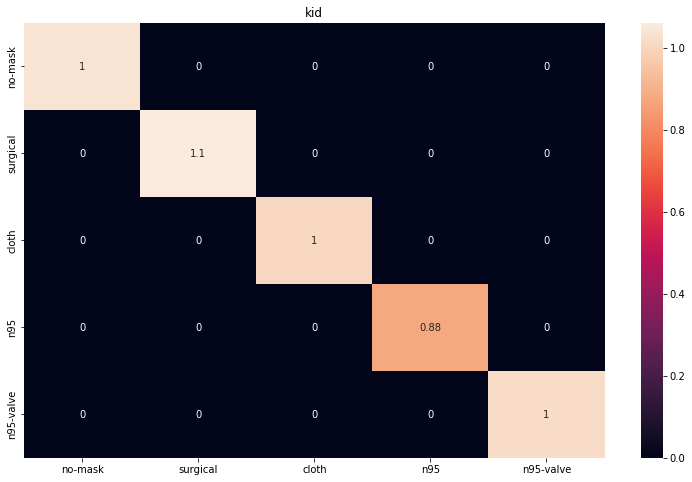

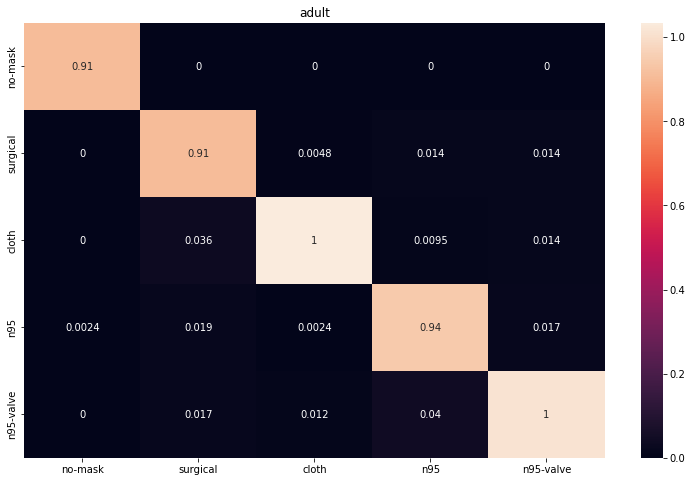

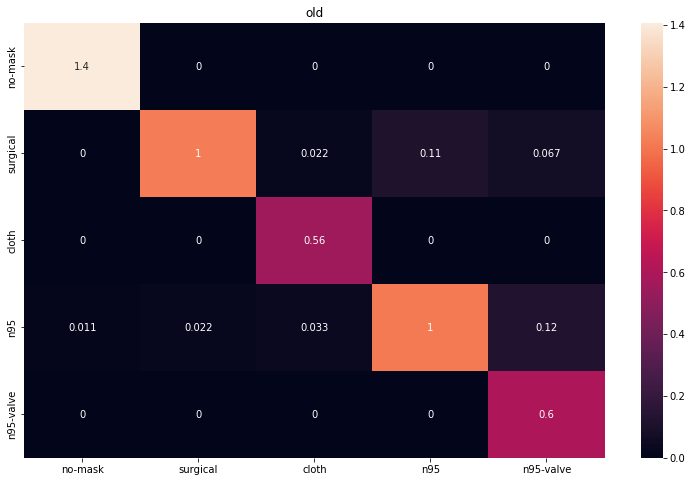

In [10]:
for i, age in enumerate(dataset.age_types):
    cf_matrix = confusion_matrix(y_true_age[i], y_pred_age[i])

    df_cm = pd.DataFrame(
        cf_matrix / np.sum(cf_matrix) * 5, 
        index = [i for i in dataset.labels], 
        columns = [i for i in dataset.labels])
    plt.figure(figsize = (13,8))
    plt.title(age)
    sn.heatmap(df_cm, annot=True)

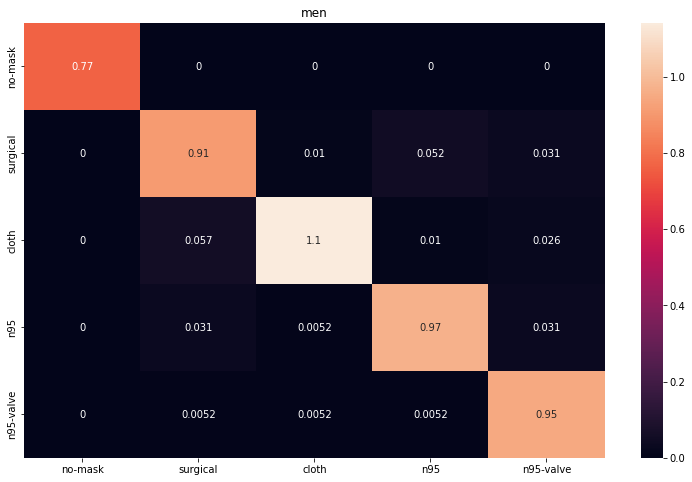

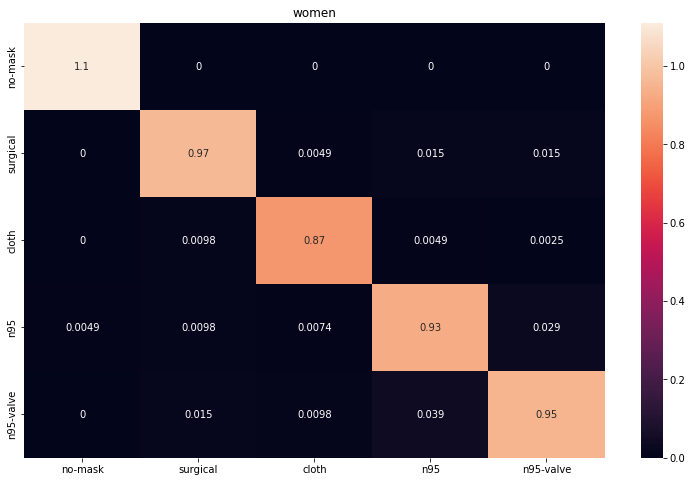

In [11]:
for i, gender in enumerate(dataset.gender_types):
    cf_matrix = confusion_matrix(y_true_gender[i], y_pred_gender[i])

    df_cm = pd.DataFrame(
        cf_matrix / np.sum(cf_matrix) * 5, 
        index = [i for i in dataset.labels], 
        columns = [i for i in dataset.labels])
    plt.figure(figsize = (13,8))
    plt.title(gender)
    sn.heatmap(df_cm, annot=True)

    plt.show()

### Metrics

In [12]:
for i, age in enumerate(dataset.age_types):
    print(f'{age}: ')
    print(f'\taccuracy: {accuracy_score(y_true_age[i], y_pred_age[i]):.3f}')
    print(f'\trecall: {recall_score(y_true_age[i], y_pred_age[i], average="weighted"):.3f}')
    print(f'\tprecision: {precision_score(y_true_age[i], y_pred_age[i], average="weighted"):.3f}')
    print(f'\tf1: {f1_score(y_true_age[i], y_pred_age[i], average="weighted"):.3f}')

kid: 
	accuracy: 1.000
	recall: 1.000
	precision: 1.000
	f1: 1.000
adult: 
	accuracy: 0.960
	recall: 0.960
	precision: 0.960
	f1: 0.960
old: 
	accuracy: 0.922
	recall: 0.922
	precision: 0.930
	f1: 0.922


In [13]:
for i, gender in enumerate(dataset.gender_types):
    print(f'{gender}: ')
    print(f'\taccuracy: {accuracy_score(y_true_gender[i], y_pred_gender[i]):.3f}')
    print(f'\trecall: {recall_score(y_true_gender[i], y_pred_gender[i], average="weighted"):.3f}')
    print(f'\tprecision: {precision_score(y_true_gender[i], y_pred_gender[i], average="weighted"):.3f}')
    print(f'\tf1: {f1_score(y_true_gender[i], y_pred_gender[i], average="weighted"):.3f}')

men: 
	accuracy: 0.946
	recall: 0.946
	precision: 0.947
	f1: 0.946
women: 
	accuracy: 0.967
	recall: 0.967
	precision: 0.967
	f1: 0.967
